## First pratical of the Unsupervised Language Learning course 2017-2018

Joris Mollinga: 11871431 

Aron Hammond: 10437215

In [1]:
import numpy as np
import os
import sklearn
import pprint
from collections import deque
from sklearn.cluster import KMeans
from scipy.stats import spearmanr
from scipy.stats import pearsonr 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import random

In [2]:
def cosine_sim(a,b):
    t = np.dot(a,b)
    n = np.linalg.norm(a) * np.linalg.norm(b)
    return t/n

In [3]:
# Read the word embeddings file
def readWORDSfile(fileName):
    word2vec = []
    
    w2i = {}
    i2w = {}

    with open (fileName,'r',encoding="utf8") as emb:
        i = 0
        for line in emb:
            row = line.split()
            word = row[0]
            embedding = row[1:]

            # Convert to floats and assign in dictionary
            word2vec.append([float(i) for i in embedding])
            
            i2w[i] = word
            w2i[word] = i
            i += 1
            
    return np.array(word2vec),i2w,w2i

def read2000words(fileName):
        
    with open (fileName,'r') as nouns:
        words = nouns.readlines()
        
    words = [i.strip() for i in words]
            
    return words

def readMEN(fileName):
    judgements = []
    
    with open (fileName,'r') as file:
        for line in file:
            judgements.append(line.split())
    
    return judgements

def readSimLex(fileName):
    judgements = []
    
    with open (fileName,'r') as file:
        for i, line in enumerate(file):
            if i == 0: continue
            judgement = line.split('\t')
            judgements.append([judgement[0], judgement[1], judgement[3]])
            
    return judgements

In [4]:
word2vec, W2V_i2w, W2V_w2i = readWORDSfile('deps.WORDS')

In [5]:
bow2, bow2_i2w, bow2_w2i = readWORDSfile('bow2.WORDS')

In [6]:
bow5, bow5_i2w, bow5_w2i = readWORDSfile('bow5.WORDS')

In [10]:
words = read2000words('2000_nouns_sorted.txt')
w2v_nouns = []
bow2_nouns = []
bow5_nouns = []
removeList = []

for word in words:
    try:
        w2v_nouns.append(word2vec[W2V_w2i[word]])
        bow2_nouns.append(bow2[bow2_w2i[word]])
        bow5_nouns.append(bow5[bow5_w2i[word]])
    except:
        removeList.append(word)

for word in removeList:
    words.remove(word)

In [ ]:
def find_closest_word(word,embeddings,i2w,n=1):
    if n == 1:
        sim = [cosine_sim(embeddings[i],word) for i in range(0,len(embeddings))]
        idx = sim.index(max(sim))
        return i2w[idx]
    else:
        sim = [cosine_sim(embeddings[i],word) for i in range(0,len(embeddings))]
        idx = sorted(range(len(sim)), key=lambda i: sim[i])[-n:]
        return list(reversed([i2w[i] for i in idx]))

# Word Similarity

In [9]:
men = readMEN(os.path.join('MEN', 'MEN_dataset_natural_form_full'))

In [10]:
simlex = readSimLex(os.path.join('SimLex-999', 'SimLex-999.txt'))

In [11]:
def similarity(word1, word2, model, w2i):
    '''Compute the cosine similarity of the embeddings of word1 and word2 under the supplied model'''
    
    if not word1 in w2i or not word2 in w2i:
        return 0
    
    emb1 = model[w2i[word1]]
    emb2 = model[w2i[word2]]
    
    unit_emb1 = np.array(emb1) / np.linalg.norm(emb1)
    unit_emb2 = np.array(emb2) / np.linalg.norm(emb2)
    
    return np.dot(unit_emb1, unit_emb2)

def evaluate_models_on_set(judgements):
    result = []
    used = []
    
    for pair in judgements:
        word1, word2, score = pair
        bow2sim = similarity(word1, word2, bow2, bow2_w2i)
        bow5sim = similarity(word1, word2, bow5, bow5_w2i)
        depssim = similarity(word1, word2, word2vec, W2V_w2i)
        
        row = [bow2sim, bow5sim, depssim]
                
        if not all(row):
            continue
        
        result.append(row)
        used.append(pair)
    
    return np.array(result, dtype=np.float64), used

def pearson(results, scores):
    corr = []
    for i in range(np.size(results, 1)):
        corr.append(pearsonr(results[:,i], scores)[0])
        
    return np.array(corr)    

# Compute cosine similarity between the words using the three models
# words that don't occur in the models are skipped and removed from
# the evaluation set.
MENResults, men = evaluate_models_on_set(men)
SimLexResults, simlex = evaluate_models_on_set(simlex)
    
# Evaluate the model-produced similarities against human judgements in terms of 
# Pearson and Spearman correlation coefficients.

# Collect human judgements (last column of dataset)
MENScores = np.array([judgement[-1] for judgement in men], dtype=np.float64)
SimLexScores = np.array([judgement[-1] for judgement in simlex], dtype=np.float64)

correlations = {"MEN" : {
                   "Spearman" : [],
                   "Pearson" : []},
               "SimLex" : {
                   "Spearman" : [],
                   "Pearson" : []
               }}

correlations["MEN"]["Spearman"] = spearmanr(MENResults, MENScores, axis = 0).correlation[0:3,-1]
correlations["MEN"]["Pearson"] = pearson(MENResults, MENScores)
correlations["SimLex"]["Spearman"] = spearmanr(SimLexResults, SimLexScores, axis = 0).correlation[0:3,-1]
correlations["SimLex"]["Pearson"] = pearson(SimLexResults, SimLexScores)

pprint.pprint(correlations)

# Compare the performance of the three models on this task.

#  Analyze the data qualitatively and report what are the differences in the kind
# of similarity captured by the three models.

{'MEN': {'Pearson': array([ 0.67769822,  0.70823625,  0.5974016 ]),
         'Spearman': array([ 0.69990476,  0.72316866,  0.61782279])},
 'SimLex': {'Pearson': array([ 0.42845866,  0.3756006 ,  0.46190134]),
            'Spearman': array([ 0.41414577,  0.36739614,  0.44564093])}}


# Word Analogy

In [28]:
def read_question_words(filename):
    analogies = []
    
    with open(filename) as f:
        for line in f:
            elements = line.split()
            
            # words in embedding models are all lowercased
            elements = [i.lower() for i in elements]
            
            # analogies are divided into sections by a line of the form ": capital-common-contries"
            if not elements[0] == ':':
                analogies.append(elements)
    
    return analogies

def reciprocal_rank(target, candidates):    
    try:
        rank = candidates.index(target) + 1
    except:
        return 0
        
    return 1/rank

question_words = read_question_words('questions-words.txt')

In [23]:
MRR = {"bow2" : 0, "bow5" : 0, "deps" : 0}
acc = {"bow2" : 0, "bow5" : 0, "deps" : 0}

model_data = {"bow2" : (bow2, bow2_i2w, bow2_w2i), 
              "bow5" : (bow5, bow5_i2w, bow5_w2i), 
              "deps" : (word2vec, W2V_i2w, W2V_w2i)}

for label, model in model_data.items():
    embeddings = model[0]
    i2w = model[1]
    w2i = model[2]
        
    RR = 0
    correct = 0
    sample_size = 100
    sample = random.sample(question_words, sample_size)
    
    for i, analogy in enumerate(sample):
        
        # Find embeddings corresponding to the analogy
        # but leave b_prime as the target
        try:
            a,a_prime,b,b_prime = analogy
            a_idx, a_prime_idx, b_idx = w2i[a], w2i[a_prime], w2i[b]
            a = embeddings[a_idx]
            a_prime = embeddings[a_prime_idx]
            b = embeddings[b_idx]
        except:
            sample_size = sample_size - 1
            continue
        
        # Estimate for b_prime based on our model
        b_prime_est = np.array(b) + (np.array(a_prime) - np.array(a))
        b_prime_est = b_prime_est.reshape(1,-1)
        
        scores = cosine_similarity(embeddings, b_prime_est)
        scores[b_idx] = 0
        scores[a_idx] = 0
        scores[a_prime_idx] = 0
        sorted_idx = np.argsort(scores, axis=0)
        
        top5 = [i2w[idx] for idx in sorted_idx[-5:, 0]]
        closest_words = list(reversed(top5))
        
        print(analogy)
        print(closest_words)
        print()
        
        if i % 100 == 0:
            print(i)
        
        # Count correctly estimated words
        if closest_words[0] == b_prime:
            correct += 1
        
        # Sum up reciprocal rankings (0 if not in set)
        RR += reciprocal_rank(b_prime, closest_words)
    
    # Average statistics over the entire set
    MRR[label] = RR / sample_size
    acc[label] = correct / sample_size

print("MRR")
pprint.pprint(MRR)
print()
print("Accuracy")
pprint.pprint(acc)

0
0
0
{'bow2': 0.7586666666666667,
 'bow5': 0.7423333333333332,
 'deps': 0.33349999999999996}
{'bow2': 0.7, 'bow5': 0.68, 'deps': 0.29}


In [ ]:
## Visually inspect analogies, sorted by analogy rather than by model

examples = read_question_words('example-analogies.txt')

for analogy in examples:
    for label, model in model_data.items():
        embeddings = model[0]
        i2w = model[1]
        w2i = model[2]

        # Find embeddings corresponding to the analogy
        # but leave b_prime as the target
        try:
            a,a_prime,b,b_prime = analogy
            a_idx, a_prime_idx, b_idx = w2i[a], w2i[a_prime], w2i[b]
            a = embeddings[a_idx]
            a_prime = embeddings[a_prime_idx]
            b = embeddings[b_idx]
        except:
            sample_size = sample_size - 1
            continue

        # Estimate for b_prime based on our model
        b_prime_est = np.array(b) + (np.array(a_prime) - np.array(a))
        b_prime_est = b_prime_est.reshape(1,-1)

        scores = cosine_similarity(embeddings, b_prime_est)
        scores[b_idx] = 0
        scores[a_idx] = 0
        scores[a_prime_idx] = 0
        sorted_idx = np.argsort(scores, axis=0)

        top5 = [i2w[idx] for idx in sorted_idx[-5:, 0]]
        closest_words = list(reversed(top5))

        print(label)
        print(analogy)
        print(closest_words)
        print()

# Clustering

## PCA

In [7]:
pca2 = PCA(n_components=2)
Xw2v = pca2.fit_transform(word2vec)
Xbow2 = pca2.fit_transform(bow2)
Xbow5 = pca2.fit_transform(bow5)

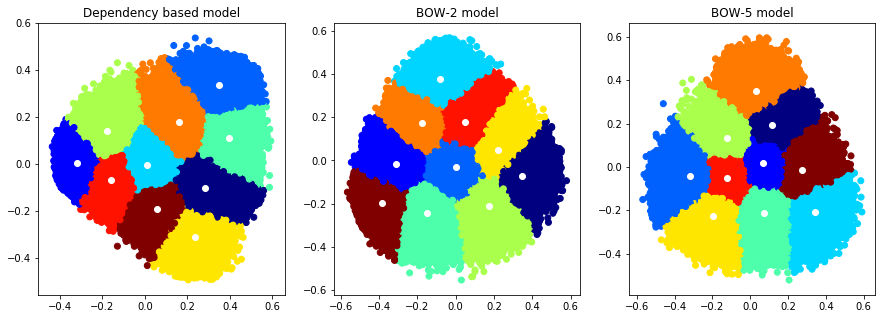

In [8]:
num_clusters = 10
kmeans_w2v = KMeans(n_clusters = num_clusters,random_state = 0).fit(Xw2v)
predict_w2v = kmeans_w2v.predict(Xw2v)
centers_w2v = kmeans_w2v.cluster_centers_

kmeans_bow2 = KMeans(n_clusters = num_clusters,random_state = 0).fit(Xbow2)
predict_bow2 = kmeans_bow2.predict(Xbow2)
centers_bow2 = kmeans_bow2.cluster_centers_

kmeans_bow5 = KMeans(n_clusters = num_clusters,random_state = 0).fit(Xbow5)
predict_bow5 = kmeans_bow5.predict(Xbow5)
centers_bow5 = kmeans_bow5.cluster_centers_

f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))
ax1.scatter(Xw2v[:,0],Xw2v[:,1], c=predict_w2v,cmap= 'jet')
ax1.scatter(centers_w2v[:,0],centers_w2v[:,1],c='1.0')
ax1.set_title('Dependency based model')

ax2.scatter(Xbow2[:,0],Xbow2[:,1], c=predict_bow2,cmap= 'jet')
ax2.scatter(centers_bow2[:,0],centers_bow2[:,1],c='1.0')
ax2.set_title('BOW-2 model')

ax3.scatter(Xbow5[:,0],Xbow5[:,1], c=predict_bow5,cmap= 'jet')
ax3.scatter(centers_bow5[:,0],centers_bow5[:,1],c='1.0')
ax3.set_title('BOW-5 model')
plt.show()

## TSNE

In [104]:
n_sne = 50000 # number of samples
pca30 = PCA(n_components=50)

random_sample = random.sample(list(word2vec.values()),n_sne)

w2v_pca_30 = pca30.fit_transform(random_sample)
print ('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca30.explained_variance_ratio_)))
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
w2v_tsne_pca_results = tsne.fit_transform(w2v_pca_30)

Cumulative explained variation for 50 principal components: 0.7292298586760423
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.343s...
[t-SNE] Computed neighbors for 50000 samples in 445.584s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabi

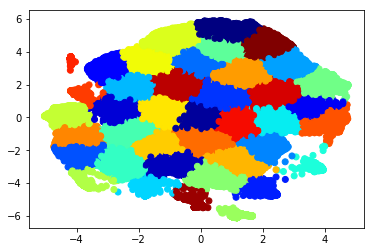

In [105]:
kmeans_tsne = KMeans(n_clusters = 40,random_state = 0).fit(w2v_tsne_pca_results)
predict_tsne = kmeans_tsne.predict(w2v_tsne_pca_results)
centers_tsne = kmeans_tsne.cluster_centers_

plt.scatter(w2v_tsne_pca_results[:,0],w2v_tsne_pca_results[:,1], c=predict_tsne, cmap= 'jet')
plt.show()

## Clustering

In [11]:
num_clusters = 200
kmeans_w2v_nouns = KMeans(n_clusters = num_clusters,random_state = 0).fit(w2v_nouns)
centers_w2v_nouns = kmeans_w2v_nouns.cluster_centers_
predict_w2v_nouns = kmeans_w2v_nouns.predict(w2v_nouns)

word_list = [[] for x in range(num_clusters)]
assert len(predict_w2v_nouns) == len(words)

for cluster,word in zip(predict_w2v_nouns,words):
    word_list[cluster].append(word)
    
''' 
print_all_clusters = False
if print_all_clusters:
    for cluster in word_list:
        print (cluster)
        print ('')
else:
    samples = random.sample(word_list,10)
    for sample in samples:
        print (sample)
        print ('')
'''        
for cluster in word_list:
    if 'money' in cluster:
        print (cluster)
    elif 'italy' in cluster:
        print (cluster)
    elif 'scientist' in cluster:
        print (cluster)  

['britain', 'china', 'france', 'germany', 'gorbachev', 'hitler', 'iraq', 'israel', 'italy', 'japan', 'kingdom', 'moscow', 'republic', 'rome', 'russia', 'spain', 'union']
['architect', 'author', 'critic', 'designer', 'editor', 'engineer', 'historian', 'journalist', 'lawyer', 'photographer', 'poet', 'politician', 'producer', 'reporter', 'researcher', 'scholar', 'scientist', 'writer']
['cash', 'money']


In [12]:
num_clusters = 200
kmeans_bow2_nouns = KMeans(n_clusters = num_clusters,random_state = 0).fit(bow2_nouns)
centers_bow2_nouns = kmeans_bow2_nouns.cluster_centers_
predict_bow2_nouns = kmeans_bow2_nouns.predict(bow2_nouns)

word_list = [[] for x in range(num_clusters)]
assert len(predict_bow2_nouns) == len(words)

for cluster,word in zip(predict_bow2_nouns,words):
    word_list[cluster].append(word)
    
''' 
print_all_clusters = False
if print_all_clusters:
    for cluster in word_list:
        print (cluster)
        print ('')
else:
    samples = random.sample(word_list,10)
    for sample in samples:
        print (sample)
        print ('')
'''        
for cluster in word_list:
    if 'money' in cluster:
        print (cluster)
    elif 'italy' in cluster:
        print (cluster)
    elif 'scientist' in cluster:
        print (cluster)  

['accountant', 'analyst', 'commentator', 'consultant', 'critic', 'engineer', 'expert', 'historian', 'lawyer', 'practitioner', 'reporter', 'researcher', 'resident', 'scholar', 'scientist', 'specialist', 'student', 'teacher']
['card', 'cash', 'cheque', 'deposit', 'desk', 'fortune', 'gift', 'mail', 'money', 'packet', 'payment', 'receipt', 'ticket']
['britain', 'england', 'europe', 'france', 'germany', 'iraq', 'ireland', 'israel', 'italy', 'japan', 'kingdom', 'kong', 'rome', 'russia', 'scotland', 'spain']


In [13]:
num_clusters = 200
kmeans_bow5_nouns = KMeans(n_clusters = num_clusters,random_state = 0).fit(bow5_nouns)
centers_bow5_nouns = kmeans_bow5_nouns.cluster_centers_
predict_bow5_nouns = kmeans_bow5_nouns.predict(bow5_nouns)

word_list = [[] for x in range(num_clusters)]
assert len(predict_bow5_nouns) == len(words)

for cluster,word in zip(predict_bow5_nouns,words):
    word_list[cluster].append(word)

''' 
print_all_clusters = False
if print_all_clusters:
    for cluster in word_list:
        print (cluster)
        print ('')
else:
    samples = random.sample(word_list,10)
    for sample in samples:
        print (sample)
        print ('')
'''        
for cluster in word_list:
    if 'money' in cluster:
        print (cluster)
    elif 'italy' in cluster:
        print (cluster)
    elif 'scientist' in cluster:
        print (cluster)  

['analyst', 'commentator', 'consultant', 'doctor', 'engineer', 'expert', 'figure', 'historian', 'lawyer', 'politician', 'researcher', 'scholar', 'scientist']
['britain', 'china', 'france', 'germany', 'gorbachev', 'india', 'iraq', 'israel', 'italy', 'japan', 'kong', 'moscow', 'paris', 'republic', 'rome', 'russia', 'spain', 'union']
['cash', 'charity', 'credit', 'fortune', 'fund', 'gift', 'money', 'spending']
